# Lab13-2: GAN
<hr>

110062802 呂宸漢

Implement the [Improved WGAN](https://arxiv.org/pdf/1704.00028.pdf) (WGAN-GP) and train it on [CelebA](https://www.kaggle.com/c/datalab-lab-14-2/data) dataset.


## Environment Setting

In [1]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2022-12-07 14:40:08.941051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2 Physical GPUs, 1 Logical GPUs


## Utility Function

In [2]:
import numpy as np
import imageio
import moviepy.editor as mpy


def make_puzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h: (j + 1) * h, i * w: (i + 1) * w, :] = img
    if path is not None:
        imageio.imwrite(path, out)
    return out


def make_gif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t: imgs[int(n * t)], duration=duration)
    clip.write_gif(fname, fps=n)


## Parameter Setting

In [3]:
import os

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BUFFER_SIZE = 65536
BATCH_SIZE = 500
Z_DIM = 128

LEARNING_RATE = 1e-4
BETA_1 = 0
BETA_2 = 0.9
LAMBDA = 10
EPOCH = 250

SAMPLE_COL = 10
SAMPLE_ROW = 10
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW
IMG_DIR = './imgs/'
if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)


## Build Dataset

In [4]:
import glob


def map_train(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32)
    img = img / 255.
    return img


img_name_list = sorted(glob.glob('./dataset/img_align_celeba_png/*.png'))
dataset_train = tf.data.Dataset.from_tensor_slices(img_name_list)\
                               .map(map_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


## Build Model

In [5]:
import tensorflow.keras as keras


def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4

    # return Generator and Discriminator
    return keras.Sequential([  # Generator
        keras.layers.Dense(units=1024, input_shape=(z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units=zh*zw*256),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape=(zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=5,
            strides=2,
            padding='SAME'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters=xc,
            kernel_size=5,
            strides=2,
            padding='SAME',
            activation=keras.activations.sigmoid
        ),
    ]), keras.Sequential([  # Discriminator
        keras.layers.Conv2D(
            filters=32,
            kernel_size=5,
            strides=(2, 2),
            padding='SAME',
            input_shape=img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters=128,
            kernel_size=5,
            strides=(2, 2),
            padding='SAME'
        ),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1024),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units=1),
    ])


In [6]:
G, D = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(LEARNING_RATE, BETA_1, BETA_2)
optimizer_d = keras.optimizers.Adam(LEARNING_RATE, BETA_1, BETA_2)


@tf.function
def G_train_step(real_data):
    z = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as tape:
        fake_data = G(z, training=True)

        D_fake = D(fake_data, training=True)
        D_real = D(real_data, training=True)

        loss_g = tf.reduce_mean(-D_fake)

        epsilon = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        interpolates = epsilon * real_data + (1 - epsilon) * fake_data
        slopes = tf.gradients(D(interpolates, training=True), interpolates)[0]
        l2_norm = tf.sqrt(tf.reduce_sum(slopes ** 2, axis=[1, 2, 3]))
        gradient_penalty = (l2_norm - 1.) ** 2

        loss_d = tf.reduce_mean(D_fake - D_real + LAMBDA * gradient_penalty)

    gradient_g = tape.gradient(loss_g, G.trainable_variables)
    optimizer_g.apply_gradients(zip(gradient_g, G.trainable_variables))

    return loss_g, loss_d


@tf.function
def D_train_step(real_data):
    z = tf.random.normal([BATCH_SIZE, Z_DIM])

    with tf.GradientTape() as tape:
        fake_data = G(z, training=True)

        D_fake = D(fake_data, training=True)
        D_real = D(real_data, training=True)

        loss_g = tf.reduce_mean(-D_fake)

        epsilon = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        interpolates = epsilon * real_data + (1 - epsilon) * fake_data
        slopes = tf.gradients(D(interpolates, training=True), interpolates)[0]
        l2_norm = tf.sqrt(tf.reduce_sum(slopes ** 2, axis=[1, 2, 3]))
        gradient_penalty = (l2_norm - 1.) ** 2

        loss_d = tf.reduce_mean(D_fake - D_real + LAMBDA * gradient_penalty)

    gradient_d = tape.gradient(loss_d, D.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, D.trainable_variables))

    return loss_g, loss_d


In [7]:
train_step = (
    D_train_step,
    D_train_step,
    D_train_step,
    D_train_step,
    D_train_step,
    G_train_step
)

num_critic = len(train_step)


## Train Model

 10%|▉         | 24/250 [11:27<1:42:34, 27.23s/epoch, g_loss=-25.3, d_loss=-2.2] 

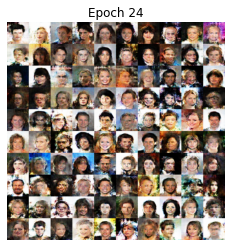

 20%|█▉        | 49/250 [22:42<1:29:19, 26.67s/epoch, g_loss=-10.5, d_loss=-1.95]

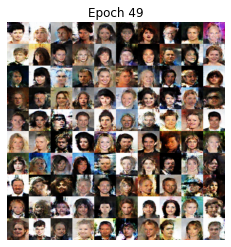

 30%|██▉       | 74/250 [33:57<1:18:19, 26.70s/epoch, g_loss=-4.44, d_loss=-1.93]

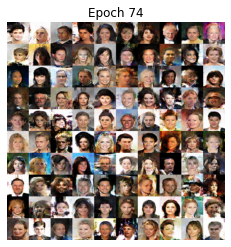

 40%|███▉      | 99/250 [45:39<1:07:05, 26.66s/epoch, g_loss=-1.74, d_loss=-1.93]

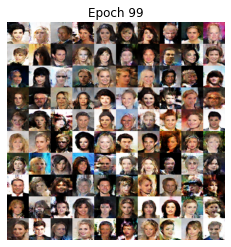

 50%|████▉     | 124/250 [58:27<55:49, 26.58s/epoch, g_loss=-1.31, d_loss=-1.92]  

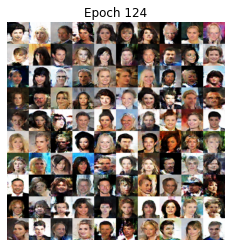

 60%|█████▉    | 149/250 [1:09:26<44:43, 26.57s/epoch, g_loss=-1.54, d_loss=-1.87]

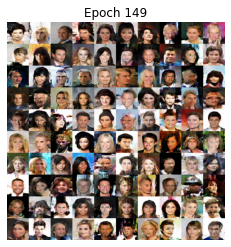

 70%|██████▉   | 174/250 [1:20:28<33:57, 26.81s/epoch, g_loss=-1.75, d_loss=-1.8] 

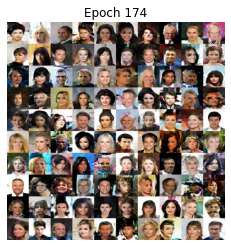

 80%|███████▉  | 199/250 [1:31:24<22:14, 26.16s/epoch, g_loss=-2.44, d_loss=-1.73]

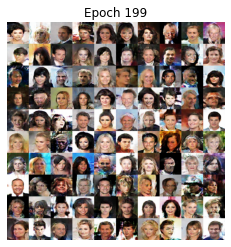

 90%|████████▉ | 224/250 [1:42:18<11:20, 26.16s/epoch, g_loss=-2.87, d_loss=-1.67]

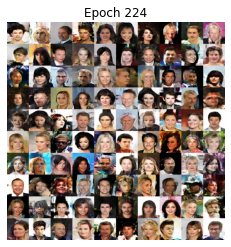

100%|█████████▉| 249/250 [1:53:12<00:26, 26.14s/epoch, g_loss=-3.76, d_loss=-1.62]

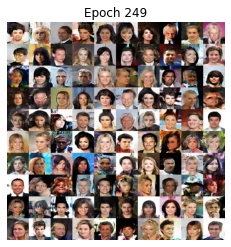

100%|██████████| 250/250 [1:53:12<00:00, 27.17s/epoch, g_loss=-3.76, d_loss=-1.62]


In [8]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt

g_loss_list = [None] * EPOCH  # record loss of g for each epoch
d_loss_list = [None] * EPOCH  # record loss of d for each epoch
sample_list = [None] * EPOCH  # record sample images for each epoch
sample_raw = tf.random.normal([SAMPLE_NUM, Z_DIM])

critic = 0
STEP = len(img_name_list) // BATCH_SIZE

pbar = trange(EPOCH, unit='epoch')
for epoch in pbar:
    loss_g_t = 0.0
    loss_d_t = 0.0
    for real_data in dataset_train:
        loss_g, loss_d = train_step[critic](real_data)
        critic = critic + 1 if critic + 1 < num_critic else 0
        loss_g_t += loss_g.numpy()
        loss_d_t += loss_d.numpy()

    g_loss_list[epoch] = loss_g_t / STEP
    d_loss_list[epoch] = loss_d_t / STEP
    pbar.set_postfix({'g_loss': loss_g_t / STEP, 'd_loss': loss_d_t / STEP})

    out = G(sample_raw, training=False)
    img = make_puzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        f'{IMG_DIR}WGAN-GP_{epoch:04d}.png'
    )
    sample_list[epoch] = img
    if (epoch + 1) % 25 == 0:
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch:d}')
        plt.show()


## Evaluate Model

In [9]:
make_gif(np.array(sample_list), f'{IMG_DIR}WGAN-GP.gif', duration=2)


MoviePy - Building file ./imgs/WGAN-GP.gif with imageio.


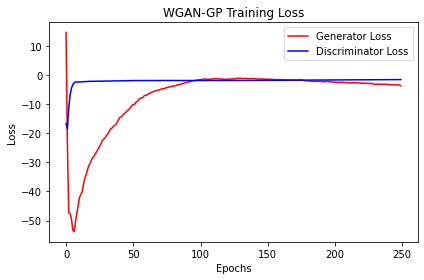

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(EPOCH), g_loss_list, color='red', label='Generator Loss')
plt.plot(range(EPOCH), d_loss_list, color='blue', label='Discriminator Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('WGAN-GP Training Loss')
plt.tight_layout()
plt.savefig(f'{IMG_DIR}WGAN-GP_Training_Loss.png', facecolor='white')
plt.show()


## Report

我的gradient penality的計算方式與[Improved WGAN](https://arxiv.org/pdf/1704.00028.pdf)的pseudo code一模一樣，optimizer與hyperparameter的設定也都根據paper的建議使用Adam並將learning rate、$\beta_1$、$\beta_2$與$\lambda$設成0.0001、0、0.9與10。而model architecture則是根據paper在[github](https://github.com/igul222/improved_wgan_training)上的architecture，將discriminator最後兩層的batch normalization拿掉以得到較好的quality。由產出的圖片可以看出大部分的人都長得蠻正常的，只有少部分的人有殘缺，不過所有圖片都還是有一些點模糊感，這點應該還要多加嘗試一些方法才能解決。
